# Plotting RBush

We want to see the structure of a RBush -- we want to plot the 2D spatial distribution of the items in a RBush tree.

We'll do that using [datashader][ds] and its companions, [xarray][xr], [bokeh][bk], [holoviews][hv], [pandas][pd], [numpy][np].

This exercise is based on:
* https://anaconda.org/jbednar/plotting_pitfalls/notebook
* https://anaconda.org/jbednar/pipeline/notebook

After a first approach, investigate/exercise the following:
* does bokeh-webgl engine support Rectangle glyph?


[ds]: http://datashader.readthedocs.io/
[xr]: http://xarray.pydata.org/
[bk]: https://bokeh.pydata.org
[hv]: http://holoviews.org/
[pd]: https://pandas.pydata.org/
[np]: http://www.numpy.org/

In [1]:
import datashader as ds
import xarray as xr
import bokeh as bk
import pandas as pd
import numpy as np
from numba import njit
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

import rbush
from rbush.data import generate_data_array

In [2]:
print(ds.__version__)
print(xr.__version__)
print(bk.__version__)
print(pd.__version__)
print(np.__version__)

0.6.4
0.10.0
0.12.13
0.20.3
1.13.1


[RBush](https://github.com/parietal-io/py-rbush)
```
rbush.__version__ : '0.0.2+9.g355496a'
```

In [3]:
import rbush

In [4]:
from rbush.data import generate_data_array

def gaussian_grid(N, INCREMENT, SIZE):
    arrays = []

    # bottom-left
    arr = generate_data_array(N, SIZE)
    arr += SIZE
    arrays.append(arr)

    # top-right
    arr = generate_data_array(N, SIZE)
    arr += INCREMENT - SIZE
    arrays.append(arr)

    # bottom-right
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT - SIZE
    arr[:,1] += SIZE
    arr[:,2] += INCREMENT - SIZE
    arr[:,3] += SIZE
    arrays.append(arr)

    # top-left
    arr = generate_data_array(N, SIZE)
    arr[:,0] += SIZE
    arr[:,1] += INCREMENT - SIZE
    arr[:,2] += SIZE
    arr[:,3] += INCREMENT - SIZE
    arrays.append(arr)

    # top-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT // 2
    arr[:,1] += INCREMENT - SIZE
    arr[:,2] += INCREMENT // 2
    arr[:,3] += INCREMENT - SIZE
    arrays.append(arr)

    # bottom-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += INCREMENT // 2
    arr[:,1] += SIZE
    arr[:,2] += INCREMENT // 2
    arr[:,3] += SIZE
    arrays.append(arr)

    # left-middle
    arr = generate_data_array(N, SIZE)
    arr[:,0] += SIZE
    arr[:,1] += INCREMENT // 2
    arr[:,2] += SIZE
    arr[:,3] += INCREMENT // 2
    arrays.append(arr)

    data = np.concatenate(arrays, axis=0)
    return data

N = int(1e5)
EXTENT = 1000
SIZE = 100
data = gaussian_grid(N, EXTENT, SIZE)
print('Length: {:,}'.format(len(data)))
data

Length: 700,000


array([[ 171.17530518,  136.29356018,  142.92398273,   32.11107991],
       [  74.58967208,  284.05013114,   85.05619135,  300.43995248],
       [  76.97631201,  251.26637766,  152.19326202,  312.94139008],
       ..., 
       [ 177.72111507,  505.45935294,  275.41495446,  590.40751966],
       [ 188.65697492,  577.61157651,  -18.29777514,  517.15049195],
       [ 143.38107413,  462.29529459,   14.40645579,  546.08632298]])

In [5]:
t = rbush.RBush()
t.load(data)

In [6]:
items = t.all()
bboxes = np.asarray([[i.xmin, i.ymin, i.xmax, i.ymax] for i in items])
bboxes

array([[-174.73062023, -244.57547762, -333.45652934, -334.85313486],
       [-161.83184695, -183.70587094,  -96.56300767, -182.81908105],
       [-147.37804754, -180.83041638, -247.07135203, -241.4477933 ],
       ..., 
       [-184.89303886, -133.6065661 , -257.08599943, -184.22325823],
       [-161.34251415, -168.5334718 ,  -95.72395547, -239.16051294],
       [ 143.38107413,  462.29529459,   14.40645579,  546.08632298]])

In [7]:
# Apart from (raw) permutations, 'data' and 'bboxes' should contain the same information
assert data.shape==bboxes.shape

In [8]:
print(data.min(axis=0))
print(data.max(axis=0))
print(data.mean(axis=0))

[-369.49965092 -367.49397317 -536.92045639 -566.5565253 ]
[ 1320.95899384  1360.07539474  1548.78749956  1599.72138775]
[ 442.86208467  499.94229441  443.00677858  499.88645428]


In [9]:
print(bboxes.min(axis=0))
print(bboxes.max(axis=0))
print(bboxes.mean(axis=0))

[-226.52965561 -244.57547762 -436.69649706 -344.98790234]
[ 596.51002268  499.9033126   640.22593823  546.08632298]
[-174.25963034 -162.39281317 -167.9754307  -214.54819405]


**We see now that RBush has a (big) bug!** To not deviate from our exercise, let's use the `data` array, it's the same structure (as `bboxes`)

Datashader works in a canvas represented by an `xarray` where each element is a bin.
The bin represents a pixel in a (data) coordinates system.
Each bin contains information aggregated from the dataset(s) at that (pixel) position.

Let's say we want to count the number of items (bounding-boxes in our dataset) that cover each position in the dataset parameters space (xmin,ymin,xmax,ymax) -- a heatmap of the items distribution.
Each bin in the datashader (xarray) canvas will contain the number counts.

As a first approach, let's do the representation of items' centroids.
Then we evolve to plotting the boxes' coverage area.

In [10]:
df = pd.DataFrame(data, columns=['xmin','ymin','xmax','ymax'])
df['x'] = df[['xmin','xmax']].mean(axis=1)
df['y'] = df[['ymin','ymax']].mean(axis=1)
df.describe()

xmin           ymin           xmax           ymax  \
count  700000.000000  700000.000000  700000.000000  700000.000000   
mean      442.862085     499.942294     443.006779     499.886454   
std       347.866854     383.532302     361.893415     396.254595   
min      -369.499651    -367.493973    -536.920456    -566.556525   
25%       120.904803     121.009064     129.204478     129.521651   
50%       432.664928     499.902679     413.090232     499.956733   
75%       785.907202     878.976130     758.849310     870.120657   
max      1320.958994    1360.075395    1548.787500    1599.721388   

                   x              y  
count  700000.000000  700000.000000  
mean      442.934432     499.914374  
std       351.392096     386.724482  
min      -393.870472    -393.613524  
25%       123.452025     123.622037  
50%       425.534592     499.913067  
75%       775.039930     876.353372  
max      1434.141298    1413.301248

In [11]:
# We will represent centroids
glyph = ds.glyphs.Point('x', 'y')

In [12]:
# Say we want to see in a resolution of "1 data-unit" of the (variable) data axes range
# TODO: Numba-isze this and take sizes / resolution.
xres = 1
yres = 1

BORDER = 100
xlims = [int(df.xmin.min()) - BORDER, int(df.xmax.max()+1) + BORDER]
ylims = [int(df.ymin.min()) - BORDER, int(df.ymax.max()+1) + BORDER]

xsize = (xlims[1] - xlims[0])//xres
ysize = (ylims[1] - ylims[0])//yres

In [13]:
def def_pos2pix(pmin,res):
    pos_zero = int(pmin/res)
    def f(pos):
        return int(pos/res) - pos_zero
    return f


def def_pix2pos(pmin,res):
    def f(pix):
        return pix*res + pmin
    return f

pos2pix_x = def_pos2pix(xlims[0], xres)
pos2pix_y = def_pos2pix(ylims[0], yres)

pix2pos_x = def_pix2pos(xlims[0], xres)
pix2pos_y = def_pix2pos(ylims[0], yres)

In [14]:
canvas = ds.Canvas(plot_width=800, plot_height=400, x_range=xlims, y_range=ylims)

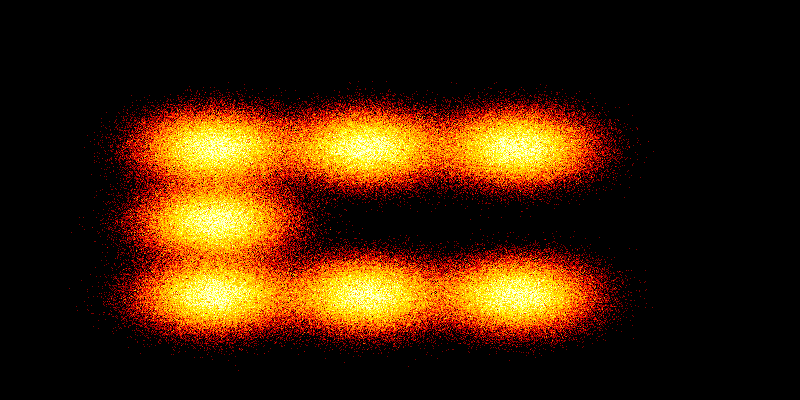

In [15]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot, viridis

img = tf.shade(canvas.points(df,'x','y', agg=reductions.count()), cmap=Hot, how='eq_hist')
tf.set_background(img, 'black')

In [16]:
# TODO: Numba-isze this and take sizes / resolution.

def pos2pix_data(a, data):
    for i in range(len(data)):
        row = data[i]
        xi = pos2pix_x(row[0])
        yi = pos2pix_y(row[1])
        xf = pos2pix_x(row[2])
        yf = pos2pix_y(row[3])
        a[yi:yf,xi:xf] += 1

a = np.zeros((ysize,xsize),dtype=int)

%time pos2pix_data(a, data)

CPU times: user 10.9 s, sys: 114 ms, total: 11 s
Wall time: 11.3 s


In [17]:
# Let's build an xarray from 'a'
# xarray have a coordinates attribute ('coords'), apart from dimensions ('dims')

xaxis = np.arange(xlims[0], xlims[1], xres)
yaxis = np.arange(ylims[0], ylims[1], yres)
axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (y: 2167, x: 2118)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) int64 -469 -468 -467 -466 -465 -464 -463 -462 -461 -460 ...
  * y        (y) int64 -467 -466 -465 -464 -463 -462 -461 -460 -459 -458 ...

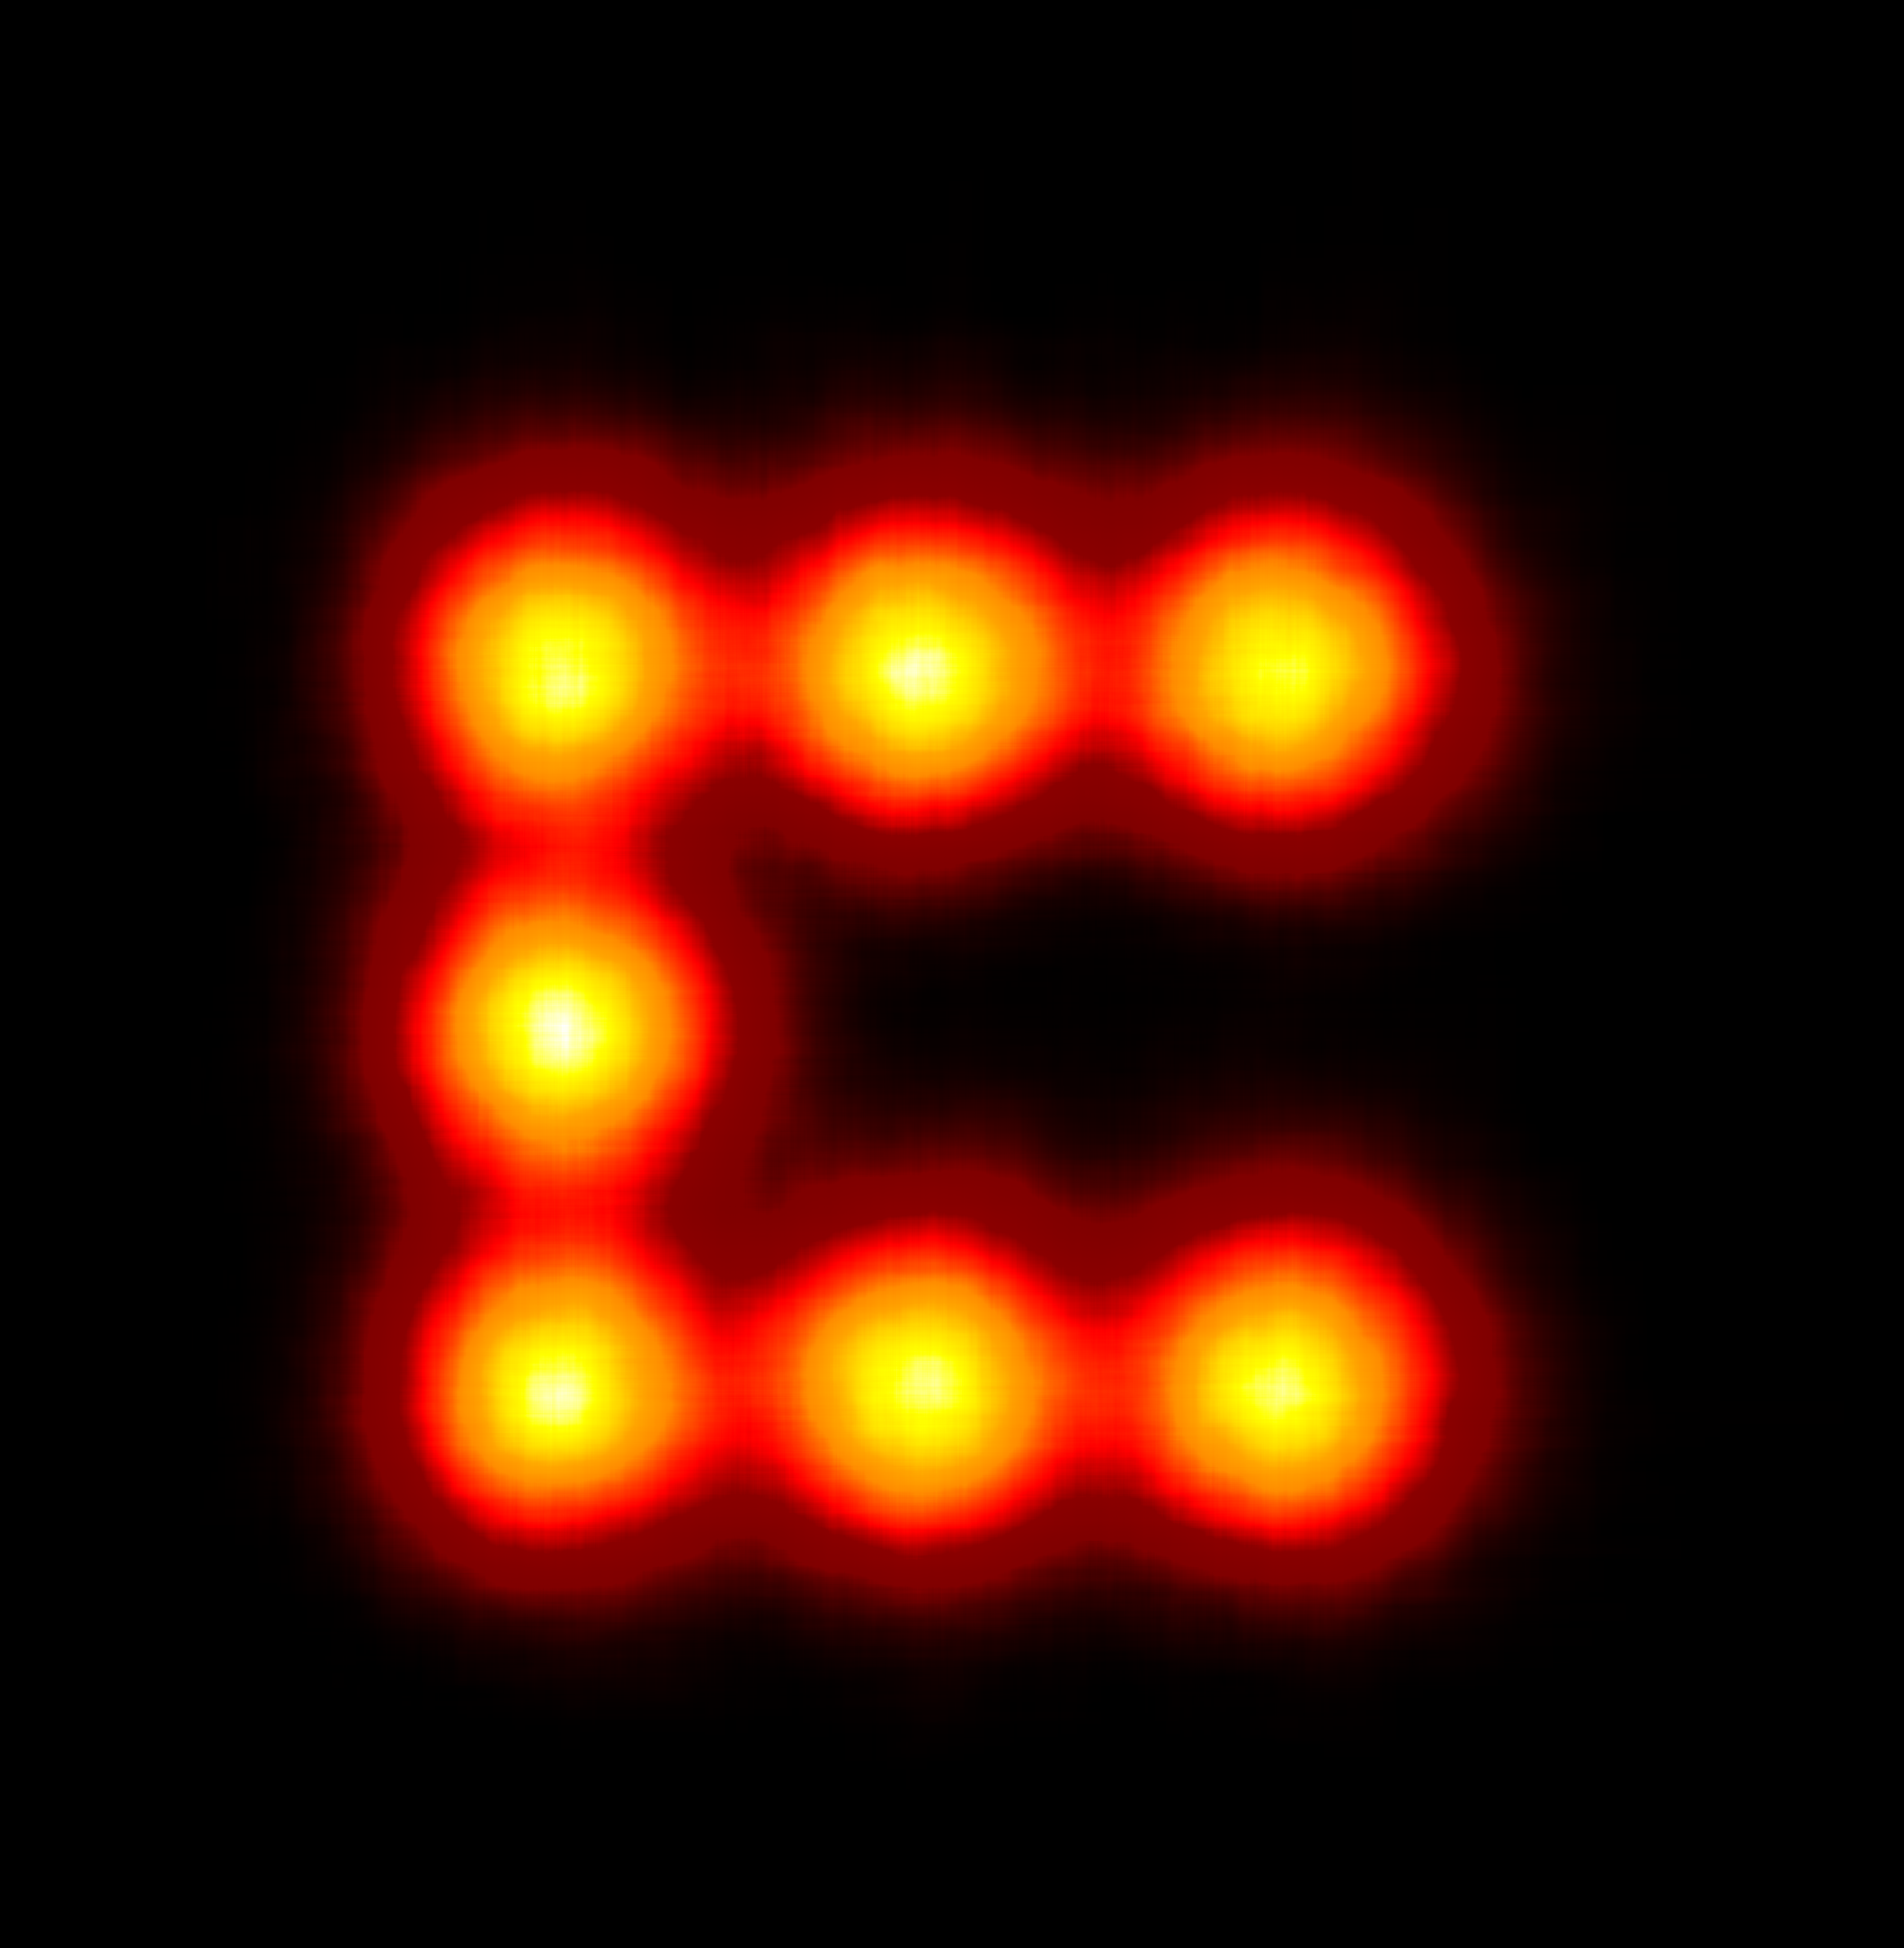

In [18]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')

# Numba version

In [19]:
from numba import guvectorize, vectorize
from numba import int64,float64,void

@vectorize(["int64(float64, float64, float64)"])
def pos2pix(pos, min_pos, res):
    return int64((pos - min_pos)/res)

@guvectorize(["void(float64[:,:], float64[:], float64[:], int64[:,:])"],
              "(n,c),(c),(c)->(n,c)")
def rasterize(arr_data, posv, resv, pix):
    for i in range(arr_data.shape[0]):
        pix[i,:] = pos2pix(arr_data[i,:], posv, resv)

@njit('void(int64[:,:],int64[:,:])')
def pos2pix_data(arr_pix, arr_canvas):
    #a = np.zeros((ysize,xsize),dtype=int)
    for i in range(arr_pix.shape[0]):
        row = arr_pix[i]
        xi = row[0]
        yi = row[1]
        xf = row[2]
        yf = row[3]
#         arr_canvas[yi:yf,xi:xf] += 1
        for y in range(yi,yf):
            for x in range(xi,xf):
                arr_canvas[y,x] += 1



a = np.zeros((ysize,xsize),dtype=int)

xmin = float(xlims[0])
ymin = float(ylims[0])
posv = np.array([xmin, ymin, xmin, ymin], dtype=float)
resv = np.array([xres, yres, xres, yres], dtype=float)

pix = np.zeros(data.shape, dtype=int)

%time rasterize(data, posv, resv, pix)
%time pos2pix_data(pix,a)

CPU times: user 131 ms, sys: 2.04 ms, total: 133 ms
Wall time: 146 ms
CPU times: user 1.64 s, sys: 24.6 ms, total: 1.67 s
Wall time: 1.75 s


In [20]:
# Let's build an xarray from 'a'
# xarray have a coordinates attribute ('coords'), apart from dimensions ('dims')

xaxis = np.arange(xlims[0], xlims[1], xres)
yaxis = np.arange(ylims[0], ylims[1], yres)
axx = xr.DataArray(a, dims=['y','x'], coords={'x':xaxis, 'y':yaxis})
axx

<xarray.DataArray (y: 2167, x: 2118)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * x        (x) int64 -469 -468 -467 -466 -465 -464 -463 -462 -461 -460 ...
  * y        (y) int64 -467 -466 -465 -464 -463 -462 -461 -460 -459 -458 ...

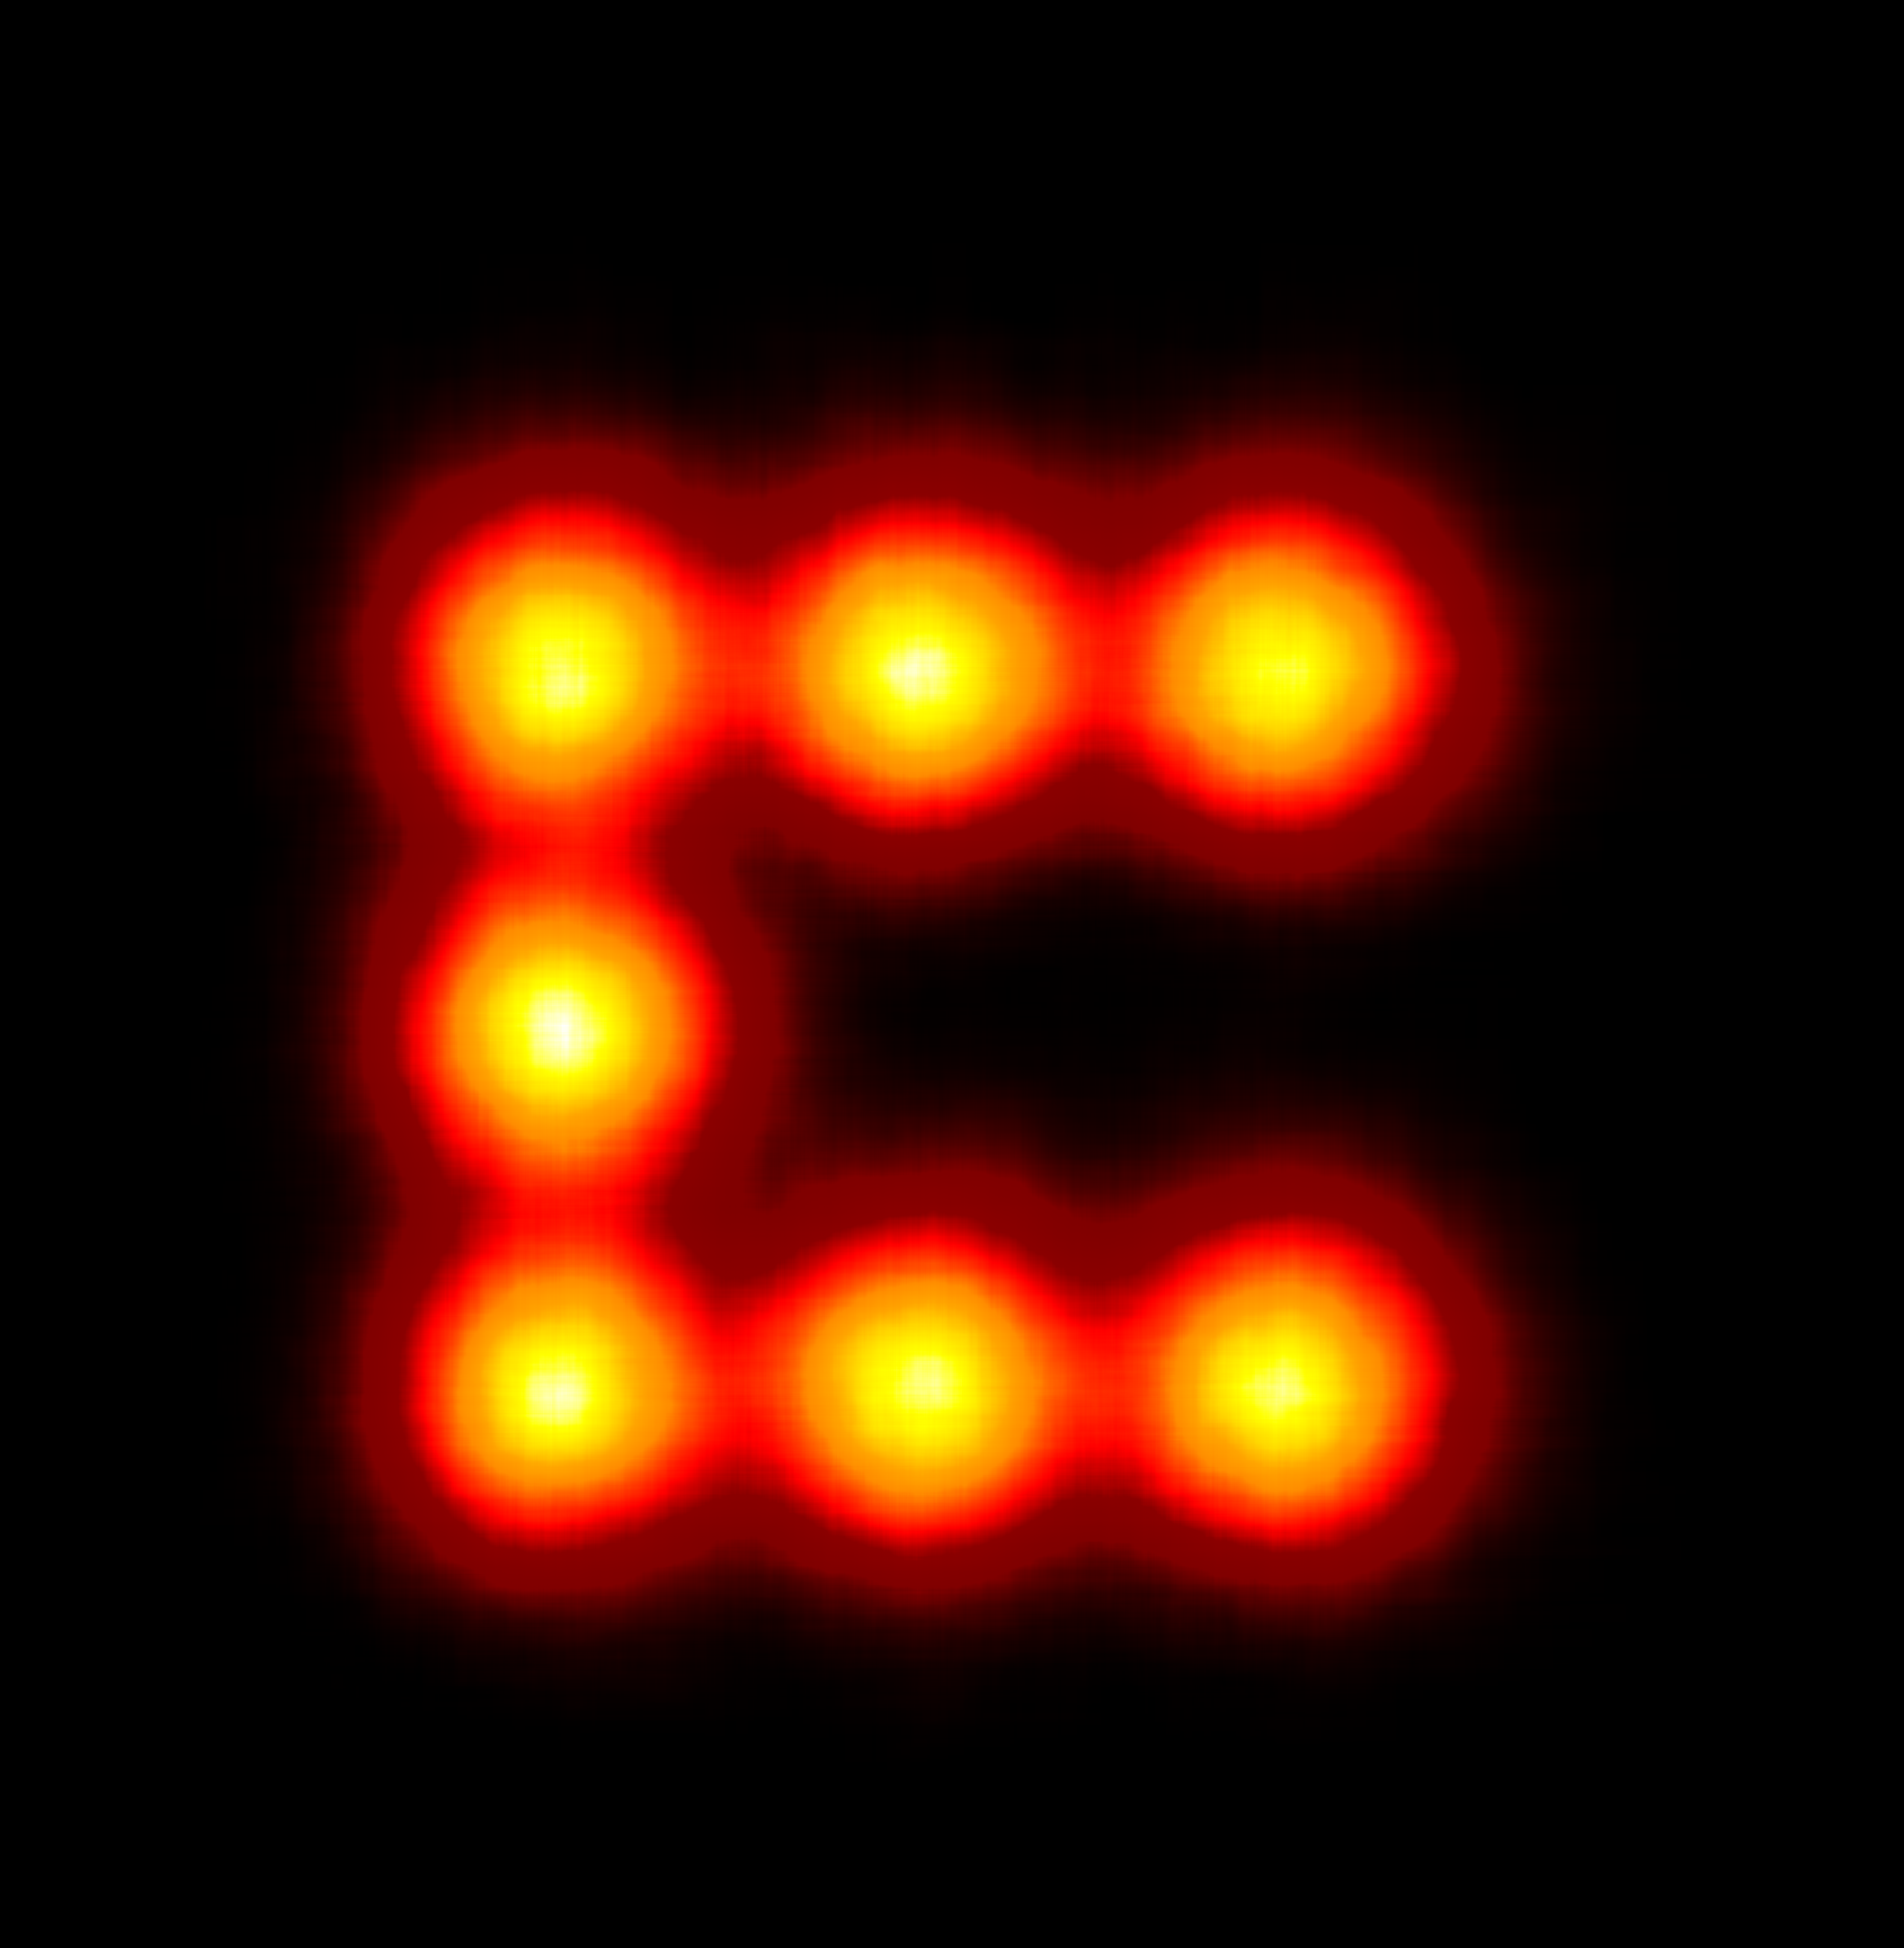

In [21]:
from datashader import transfer_functions as tf
from datashader import reductions
from datashader.colors import Hot

img = tf.shade(axx, cmap=Hot, how='linear')
tf.set_background(img, 'black')

## Interactive view

In [25]:
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()

x_range = xlims
y_range = ylims

plot_width  = int(750)
plot_height = int(plot_width//1.2)

def base_plot(tools='pan,wheel_zoom,reset',plot_width=plot_width, plot_height=plot_height, **plot_args):
    
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, **plot_args)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p
    
options = dict(line_color=None, fill_color='blue', size=5)

Loading BokehJS ...

In [26]:
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

background = "black"
export = partial(export_image, export_path="export", background=background)
cm = partial(colormap_select, reverse=(background=="black"))

def create_image(x_range, y_range, w=plot_width, h=plot_height):
    
    # query rbush for only rectangles inside of ranges
    
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(df, 'x', 'y', agg=reductions.count())
    img = tf.shade(agg, cmap=Hot, how='eq_hist')
    return tf.dynspread(img, threshold=0.5, max_px=4)

p = base_plot(background_fill_color=background)
export(create_image(x_range, y_range),"RBush")

InteractiveImage(p, create_image)
